In [66]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input)
from tensorflow.keras.optimizers import Adam

## Data Preparation

In [67]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [68]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [69]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [70]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [71]:
train_dataset

<PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Modeling

### Sampling

In [72]:
class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return mean + tf.math.exp(0.5 * log_var) * tf.random.normal(shape=(tf.shape(mean)[0], tf.shape(mean)[1]))

### Encoder

In [73]:
encoder_inputs = Input(shape=(28, 28, 1))

x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)

mean = Dense(LATENT_DIM)(x)
log_var = Dense(LATENT_DIM)(x)

z = Sampling()([mean, log_var])

encoder_model = Model(encoder_inputs, [z, mean, log_var], name='encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 32)   320         ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_4[0][0]']               
                                                                                                  
 flatten_2 (Flatten)            (None, 3136)         0           ['conv2d_5[0][0]']               
                                                                                            

### Decoder

In [74]:
latent_inputs = Input(shape=(LATENT_DIM))

x = Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = Reshape((7, 7, 64))(x)

x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder_model = Model(latent_inputs, decoder_output, name='decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_11 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 28, 28, 1)        289 

### Overall VAE Model

In [75]:
vae_input = Input(shape=(28, 28, 1), name='vae_input')
z, _, _ = encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input, output, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


In [76]:
for i in range(3):
    print(vae.layers[i])

## Training

In [77]:
OPTIMIZER = Adam(learning_rate=1e-3)
EPOCHS = 20

In [78]:
def custom_loss(y_true, y_pred, mean, log_var):
    loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis = (1, 2)))

    loss_reg = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var)), axis = 1))

    return loss_rec + loss_reg

In [79]:
@tf.function
def training_block(x_batch):
    with tf.GradientTape() as recorder:
        z, mean, log_var = encoder_model(x_batch)
        y_pred = decoder_model(z)
        y_true = x_batch
        loss = custom_loss(y_true, y_pred, mean, log_var)

    partial_derivatives = recorder.gradient(loss, vae.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, vae.trainable_weights))

    return loss

In [80]:
def learn(epochs):
    for epoch in range(1, epochs+1):
        print(f'Training starts for epoch number {epoch}')

        for step, x_batch in enumerate(train_dataset):
            loss = training_block(x_batch)
        print("Training Loss is :", loss)
    print("Training Complete")

In [16]:
learn(EPOCHS)

Training starts for epoch number 1
Training Loss is : tf.Tensor(192.62936, shape=(), dtype=float32)
Training starts for epoch number 2
Training Loss is : tf.Tensor(192.91895, shape=(), dtype=float32)
Training starts for epoch number 3
Training Loss is : tf.Tensor(181.7319, shape=(), dtype=float32)
Training starts for epoch number 4
Training Loss is : tf.Tensor(183.80487, shape=(), dtype=float32)
Training starts for epoch number 5
Training Loss is : tf.Tensor(168.78716, shape=(), dtype=float32)
Training starts for epoch number 6
Training Loss is : tf.Tensor(177.15186, shape=(), dtype=float32)
Training starts for epoch number 7
Training Loss is : tf.Tensor(174.1733, shape=(), dtype=float32)
Training starts for epoch number 8
Training Loss is : tf.Tensor(172.45433, shape=(), dtype=float32)
Training starts for epoch number 9
Training Loss is : tf.Tensor(174.03287, shape=(), dtype=float32)
Training starts for epoch number 10
Training Loss is : tf.Tensor(165.80775, shape=(), dtype=float32)
T

### Overridding train_step method

In [81]:
class VAE(tf.keras.Model):
    def __init__(self, encoder_model, decoder_model):
        super(VAE, self).__init__()
        self.encoder = encoder_model
        self.decoder = decoder_model
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
    
    @property
    def metrics(self):
        return [self.loss_tracker]
    
    def train_step(self, x_batch):
        with tf.GradientTape() as recorder:
            z, mean, log_var = encoder_model(x_batch)
            y_pred = decoder_model(z)
            y_true = x_batch
            loss = custom_loss(y_true, y_pred, mean, log_var)

        partial_derivatives = recorder.gradient(loss, self.trainable_weights)
        OPTIMIZER.apply_gradients(zip(partial_derivatives, self.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {'loss': self.loss_tracker.result()}

In [82]:
model = VAE(encoder_model, decoder_model)
model.compile(optimizer = OPTIMIZER)
model.fit(train_dataset, epochs = EPOCHS, batch_size = 128)

Epoch 1/20
547/547 [==============================] - 7s 10ms/step - loss: 205.9917
Epoch 2/20
547/547 [==============================] - 6s 10ms/step - loss: 164.1920
Epoch 3/20
547/547 [==============================] - 6s 10ms/step - loss: 159.1039
Epoch 4/20
547/547 [==============================] - 5s 10ms/step - loss: 156.7390
Epoch 5/20
547/547 [==============================] - 6s 10ms/step - loss: 155.2116
Epoch 6/20
547/547 [==============================] - 6s 10ms/step - loss: 154.2229
Epoch 7/20
547/547 [==============================] - 6s 10ms/step - loss: 153.2470
Epoch 8/20
547/547 [==============================] - 6s 10ms/step - loss: 152.6315
Epoch 9/20
547/547 [==============================] - 6s 10ms/step - loss: 152.1299
Epoch 10/20
547/547 [==============================] - 6s 10ms/step - loss: 151.7268
Epoch 11/20
547/547 [==============================] - 6s 11ms/step - loss: 151.2468
Epoch 12/20
547/547 [==============================] - 6s 10ms/step - loss

## Testing

In [83]:
scale = 1
n = 16

In [84]:
grid_x = np.linspace(-scale, scale, 16)
grid_y = np.linspace(-scale, scale, 16)

In [85]:
print(grid_x, grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


In [86]:
# plt.figure(figsize=(5, 5))
# k = 0

# for i in grid_x:
#     for j in grid_y:
#         ax = plt.subplot(n, n, k+1)

#         input = tf.constant([[i, j]])
#         out = vae.layers[2].predict(input)[0][..., 0]
#         plt.imshow(out, cmap='Greys_r')
#         plt.axis('off')
#         k += 1

1/1 [==============================] - 0s 17ms/step


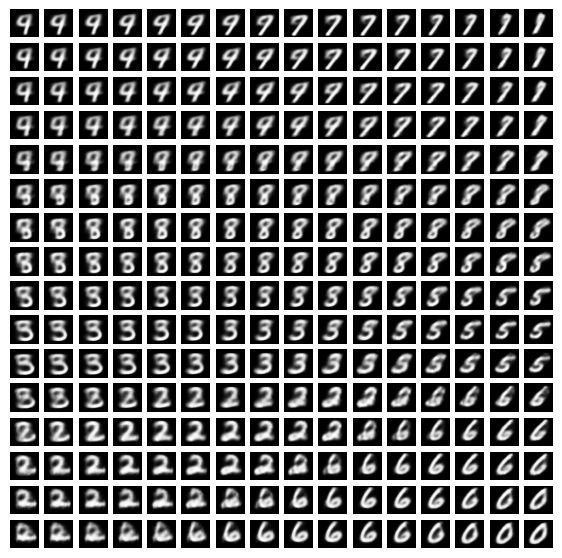

In [87]:
plt.figure(figsize=(7, 7))
k = 0

for i in grid_x:
    for j in grid_y:
        ax = plt.subplot(n, n, k+1)

        input = tf.constant([[i, j]])
        out = model.decoder.predict(input)[0][..., 0]
        plt.imshow(out, cmap='Greys_r')
        plt.axis('off')
        k += 1

In [58]:
print(vae.layers[2].predict(tf.constant([[-1, 1]]))[0][..., 0].shape)

1/1 [==============================] - 0s 88ms/step
(28, 28)


In [88]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train, -1).astype("float32") / 255

1875/1875 [==============================] - 3s 2ms/step


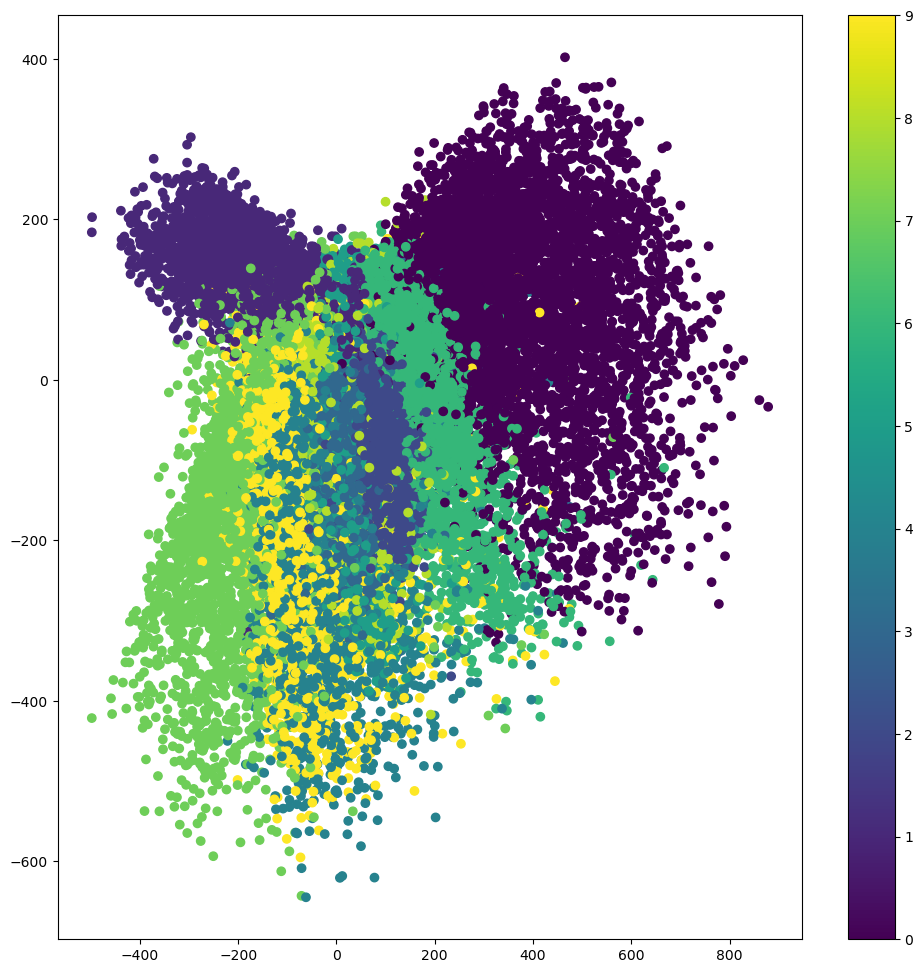

In [89]:
# z, _, _ = vae.layers[1].predict(x_train)
z, _, _ = model.encoder.predict(x_train)
plt.figure(figsize = (12, 12))
plt.scatter(z[:, 0], z[:, 1], c = y_train)
plt.colorbar()
plt.show()